In [1]:
%reload_ext autoreload
%autoreload 2

In [28]:
import sys
if ".." not in sys.path:
    sys.path.append("..")  # Append pieye module root to sys.path

from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms

from pieye.data import ClassificationDataset, get_filepaths

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Load Data

In [10]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [11]:
dataset = ClassificationDataset(annotations_filepath="../samples/annotations.txt", images_dir="../samples/images", transforms=data_transforms["train"])
len(dataset)

11

In [12]:
dataloaders = {
    "train": DataLoader(dataset, batch_size=4, shuffle=True,  num_workers=4),
}

In [6]:
class_names = ["droid", "ghost", "person"]

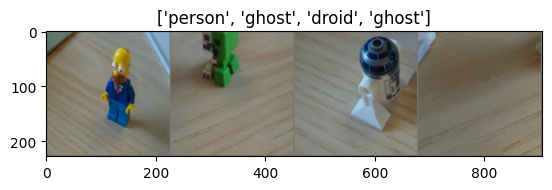

In [13]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [54]:
import os
from tempfile import TemporaryDirectory
import time


def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs, device):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        num_samples = { phase: len(dataloader.dataset) for phase, dataloader in dataloaders.items() }

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0
                epoch_loss = 0.0
                epoch_acc = 0.0

                if phase in dataloaders:
                    # Iterate over batches.
                    for inputs, labels in dataloaders[phase]:
                        inputs = inputs.to(device)
                        labels = labels.to(device)

                        # zero the parameter gradients
                        optimizer.zero_grad()

                        # forward
                        # track history if only in train
                        with torch.set_grad_enabled(phase == 'train'):
                            outputs = model(inputs)
                            _, preds = torch.max(outputs, 1)
                            loss = criterion(outputs, labels)

                            # backward + optimize only if in training phase
                            if phase == 'train':
                                loss.backward()
                                optimizer.step()

                        # statistics
                        running_loss += loss.item() * inputs.size(0)
                        running_corrects += torch.sum(preds == labels.data)

                    epoch_loss = running_loss / num_samples[phase]
                    epoch_acc = running_corrects.double() / num_samples[phase]
                if phase == 'train':
                    scheduler.step()

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Save the best model. If we don't have validation set, use training accuracy
                if epoch_acc > best_acc:
                    if ('val' in dataloaders and phase == 'val') or ('val' not in dataloaders):
                        best_acc = epoch_acc
                        torch.save(model.state_dict(), best_model_params_path)

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model


def visualize_model(model, rows=3, cols=3):
  was_training = model.training
  model.eval()
  current_row = current_col = 0
  fig, ax = plt.subplots(rows, cols, figsize=(cols*2, rows*2))

  with torch.no_grad():
    for idx, (imgs, lbls) in enumerate(dataloaders['val']):
      imgs = imgs.cpu()
      lbls = lbls.cpu()

      outputs = model(imgs)
      _, preds = torch.max(outputs, 1)

      for jdx in range(imgs.size()[0]):
        imshow(imgs.data[jdx], ax=ax[current_row, current_col])
        ax[current_row, current_col].axis('off')
        ax[current_row, current_col].set_title('predicted: {}'.format(class_names[preds[jdx]]))

        current_col += 1
        if current_col >= cols:
          current_row += 1
          current_col = 0
        if current_row >= rows:
          model.train(mode=was_training)
          return
    model.train(mode=was_training)

In [52]:
model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT)
# model = models.quantization.mobilenet_v3_large(
#     weights=models.quantization.MobileNet_V3_Large_QuantizedWeights.DEFAULT,
#     quantize=True,
# )
model.classifier
# model.classifier
# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, len(class_names))
# FIXME: AttributeError: 'QuantizableMobileNetV3' object has no attribute 'fc'

# add custom layers to prevent overfitting and for finetuning 
# model.fc = nn.Sequential(
#     nn.Dropout(0.2),
#     nn.BatchNorm1d(1280), #320
#     nn.ReLU(),
#     nn.Dropout(0.3),      
#     nn.Linear(model.fc.in, 4),
#     nn.LogSoftmax(dim=1),
# )

Sequential(
  (0): Linear(in_features=960, out_features=1280, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1280, out_features=1000, bias=True)
)

In [53]:
num_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_features, len(class_names))
model.classifier

Sequential(
  (0): Linear(in_features=960, out_features=1280, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1280, out_features=3, bias=True)
)

In [58]:
# Currently the quantized models can only be run on CPU. However, it is possible to send the non-quantized parts of the model to a GPU.
# Unlike floating point models, you don’t need to set requires_grad=False for the quantized model, as it has no trainable parameters.
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Note that we are only training the head.
optimizer = torch.optim.SGD(
    model.classifier[-1].parameters(),
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005,
)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=5, device=device)

Epoch 0/4
----------
train Loss: 1.1631 Acc: 0.2727
val Loss: 0.0000 Acc: 0.0000
Epoch 1/4
----------
train Loss: 1.0577 Acc: 0.7273
val Loss: 0.0000 Acc: 0.0000
Epoch 2/4
----------
train Loss: 0.8934 Acc: 0.7273
val Loss: 0.0000 Acc: 0.0000
Epoch 3/4
----------
train Loss: 0.7189 Acc: 0.8182
val Loss: 0.0000 Acc: 0.0000
Epoch 4/4
----------
train Loss: 0.6479 Acc: 0.8182
val Loss: 0.0000 Acc: 0.0000
Training complete in 0m 13s
Best val Acc: 0.818182


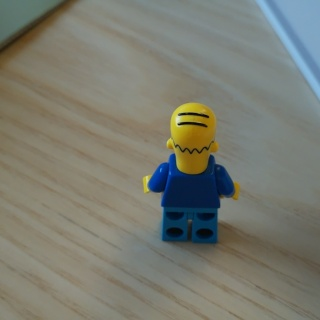

In [66]:
from PIL import Image
image = Image.open("../samples/images/1726273651.jpg")
image

In [67]:
model.eval()
with torch.no_grad():
    x = data_transforms['val'](image)
    x = x.to(device)
    pred = model(x.unsqueeze(0))


In [70]:
values, indices = pred.softmax(dim=1).max(1)
{
    "score": values.item(),
    "label": class_names[indices.item()], 
}

{'score': 0.851544201374054, 'label': 'person'}